# CSE 5368 - Spring 2021 - Final Project
## Text Summarization using Seq2Seq based model
### By Karan Jeeten Thakkar (1001852000) and Crupanshu Ashishbhai Udani (1001861781)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -U nltk # To Upgrade NLTK to >3.5 for METEOR score

     |████████████████████████████████| 1.5MB 24.2MB/s 
  Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


In [ ]:
import nltk

print('The nltk version is {}.'.format(nltk.__version__)) # Verify version >3.5

The nltk version is 3.6.2.


In [ ]:
import numpy as np 
import pandas as pd

In [ ]:
summary = pd.read_csv('/content/drive/MyDrive/NN_ProjectData/news_summary.csv', encoding='iso-8859-1')
raw = pd.read_csv('/content/drive/MyDrive/NN_ProjectData/news_summary_more.csv', encoding='iso-8859-1')

In [ ]:
pre_data1 =  raw.iloc[:,0:2].copy()

pre_data2 = summary.iloc[:,0:6].copy()
pre_data2['text'] = pre_data2['author'].str.cat(pre_data2['date'].str.cat(pre_data2['read_more'].str.cat(pre_data2['text'].str.cat(pre_data2['ctext'], sep = " "), sep =" "),sep= " "), sep = " ")

In [ ]:
pre_data = pd.DataFrame()
pre_data['text'] = pd.concat([pre_data1['text'], pre_data2['text']], ignore_index=True)
pre_data['summary'] = pd.concat([pre_data1['headlines'],pre_data2['headlines']],ignore_index = True)

In [ ]:
pre_data.head(2)

,text,summary
0,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",upGrad learner switches to career in ML & Al w...
1,Kunal Shah's credit card bill payment platform...,Delhi techie wins free food from Swiggy for on...


**Seq2Seq LSTM Modelling**

In [ ]:
pre_data['text'][:10]

0    Saurav Kant, an alumnus of upGrad and IIIT-B's...
1    Kunal Shah's credit card bill payment platform...
2    New Zealand defeated India by 8 wickets in the...
3    With Aegon Life iTerm Insurance plan, customer...
4    Speaking about the sexual harassment allegatio...
5    Pakistani singer Rahat Fateh Ali Khan has deni...
6    India recorded their lowest ODI total in New Z...
7    Weeks after ex-CBI Director Alok Verma told th...
8    Andhra Pradesh CM N Chandrababu Naidu has said...
9    Congress candidate Shafia Zubair won the Ramga...
Name: text, dtype: object

> **Perform Data Cleansing**

In [ ]:
import re

#Removes non-alphabetic characters:
def text_strip(column):
    for row in column:
        
        row=re.sub("(\\t)", ' ', str(row)).lower() #delete escape charecters
        row=re.sub("(\\r)", ' ', str(row)).lower() 
        row=re.sub("(\\n)", ' ', str(row)).lower()
        
        row=re.sub("(__+)", ' ', str(row)).lower()   #delete _ if more than one time repeatedly
        row=re.sub("(--+)", ' ', str(row)).lower()   #delete - if more than one time repeatedly
        row=re.sub("(~~+)", ' ', str(row)).lower()   #delete ~ if more than one time repeatedly
        row=re.sub("(\+\++)", ' ', str(row)).lower()   #delete + if more than one time repeatedly
        row=re.sub("(\.\.+)", ' ', str(row)).lower()   #delete . if more than one time repeatedly
        
        row=re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(row)).lower() #delete <>()|&©ø"',;?~*!
        
        row=re.sub("(mailto:)", ' ', str(row)).lower() #delete mailto:
        row=re.sub(r"(\\x9\d)", ' ', str(row)).lower() #delete \x9* in text
        row=re.sub("([iI][nN][cC]\d+)", 'INC_NUM', str(row)).lower() #replace INC nums to INC_NUM
        row=re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", 'CM_NUM', str(row)).lower() #replace CM# and CHG# to CM_NUM
        
        
        row=re.sub("(\.\s+)", ' ', str(row)).lower() #delete full stop at end of words(not between)
        row=re.sub("(\-\s+)", ' ', str(row)).lower() #delete - at end of words(not between)
        row=re.sub("(\:\s+)", ' ', str(row)).lower() #delete : at end of words(not between)
        
        row=re.sub("(\s+.\s+)", ' ', str(row)).lower() #delete any single charecters hanging between 2 spaces
        
        # Change url http://www.youtube.com/watch/43865346kcre8375 ====> www.youtube.com
        try:
            url = re.search(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', str(row))
            repl_url = url.group(3)
            row = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)',repl_url, str(row))
        except:
            pass #there might be emails with no url in them
        

        
        row = re.sub("(\s+)",' ',str(row)).lower() #delete multiple spaces
        
        #Should always be last
        row=re.sub("(\s+.\s+)", ' ', str(row)).lower() #delete any single charecters hanging between 2 spaces

        
        
        yield row




In [ ]:
cleaning1 = text_strip(pre_data['text'])
cleaning2 = text_strip(pre_data['summary'])

In [ ]:
from time import time
import spacy
nlp = spacy.load('en', disable=['ner', 'parser']) 

t = time()

text = [str(doc) for doc in nlp.pipe(cleaning1, batch_size=5000, n_threads=-1)] #spaCy.pipe() to speed-up cleaning 

#Takes 40 mins
print('Cleaning time for text: {} mins'.format(round((time() - t) / 60, 2)))

In [ ]:
t = time()

summary = ['_START_ '+ str(doc) + ' _END_' for doc in nlp.pipe(cleaning2, batch_size=5000, n_threads=-1)]

#Takes 40 mins
print('Cleaning time for summary: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 35.4 mins


In [ ]:
text[0]

In [ ]:
summary[0]

###Save the clean data to files  

In [ ]:
with open('/content/drive/MyDrive/NN_ProjectData/text.txt', "w") as f:
  for item in text:
    f.write(item + '\n')

with open('/content/drive/MyDrive/NN_ProjectData/summary.txt', "w") as f:
  for item in summary:
    f.write(item + '\n')

###Read clean data from files

In [ ]:
text1 = []
summary1 = []
text = []
summary = []

with open('/content/drive/MyDrive/NN_ProjectData/text.txt', "r") as f:
  for line in f.readlines():
    text1.append(line)

with open('/content/drive/MyDrive/NN_ProjectData/summary.txt', "r") as f:
  for line in f.readlines():
    summary1.append(line)

for item in text1:
  text.append(item.replace('\n', ''))

for item in summary1:
  summary.append(item.replace('\n', ''))

In [ ]:
pre_data['cleaned_text'] = pd.Series(text)
pre_data['cleaned_summary'] = pd.Series(summary)

In [ ]:
text_count = []
summary_count = []

In [ ]:
for sent in pre_data['cleaned_text']:
    text_count.append(len(sent.split()))
for sent in pre_data['cleaned_summary']:
    summary_count.append(len(sent.split()))

In [ ]:
graph_df= pd.DataFrame()
graph_df['text']=text_count
graph_df['summary']=summary_count

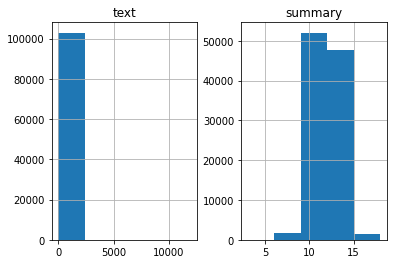

In [ ]:
import matplotlib.pyplot as plt

graph_df.hist(bins = 5)
plt.show()

In [ ]:
#Check how much % of summary have 0-15 words
count=0
for i in pre_data['cleaned_summary']:
    if(len(i.split())<=15):
        count=count+1
print(count/len(pre_data['cleaned_summary']))

0.9978234465335472


In [ ]:
#Check how much % of text have 0-70 words
count=0
for i in pre_data['cleaned_text']:
    if(len(i.split())<=100):
        count=count+1
print(count/len(pre_data['cleaned_text']))

0.9578389933440218


In [ ]:
#Model to summarize the text between 0-15 words for Summary and 0-100 words for Text

max_text_len=100
max_summary_len=15

In [ ]:
#Select the Summaries and Text between max len defined above

cleaned_text =np.array(pre_data['cleaned_text'])
cleaned_summary=np.array(pre_data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
post_pre_data=pd.DataFrame({'text':short_text,'summary':short_summary})

In [ ]:
post_pre_data.head(2)

,text,summary
0,saurav kant an alumnus of upgrad and iiit-b pg...,_START_ upgrad learner switches to career in m...
1,kunal shah credit card bill payment platform c...,_START_ delhi techie wins free food from swigg...


In [ ]:
#Add sostok and eostok at 
post_pre_data['summary'] = post_pre_data['summary'].apply(lambda x : 'sostok '+ x + ' eostok')


In [ ]:
post_pre_data.head(2)

,text,summary
0,saurav kant an alumnus of upgrad and iiit-b pg...,sostok _START_ upgrad learner switches to care...
1,kunal shah credit card bill payment platform c...,sostok _START_ delhi techie wins free food fro...


**SEQ2SEQ MODEL BUILDING **

Split the data to TRAIN and VALIDATION sets

In [ ]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(post_pre_data['text']),np.array(post_pre_data['summary']),test_size=0.1,random_state=0,shuffle=True)

In [ ]:
#Lets tokenize the text to get the vocab count , you can use Spacy here also

from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tknizer = Tokenizer() 
x_tknizer.fit_on_texts(list(x_tr))

**RARE WORD ANALYSIS FOR X i.e 'text'**
* total_count gives the size of vocabulary (which means every unique words in the text)

* count gives me the no. of rare words whose count falls below threshold

* total_count - count gives me the top most common words

In [ ]:
thresh=4

count=0
total_count=0
frequency=0
total_frequency=0

for key,value in x_tknizer.word_counts.items():
    total_count=total_count+1
    total_frequency=total_frequency+value
    if(value<thresh):
        count=count+1
        frequency=frequency+value
    
print("% of rare words in vocabulary:",(count/total_count)*100)
print("Total Coverage of rare words:",(frequency/total_frequency)*100)

% of rare words in vocabulary: 57.91270391131826
Total Coverage of rare words: 1.3404923996005096


In [ ]:

#prepare a tokenizer for reviews on training data
x_tknizer = Tokenizer(num_words=total_count-count) 
x_tknizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences (i.e one-hot encodeing all the words)
x_tr_seq    =   x_tknizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tknizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tknizer.num_words + 1

print("Size of vocabulary in X = {}".format(x_voc))

Size of vocabulary in X = 33412


**RARE WORD ANALYSIS FOR Y i.e 'summary'**
* total_count gives the size of vocabulary (which means every unique words in the text)

* count gives me the no. of rare words whose count falls below threshold

* total_count - count gives me the top most common words

In [ ]:
#prepare a tokenizer for reviews on training data
y_tknizer = Tokenizer()   
y_tknizer.fit_on_texts(list(y_tr))

In [ ]:
thresh=6

count=0
total_count=0
frequency=0
total_frequency=0

for key,value in y_tknizer.word_counts.items():
    total_count=total_count+1
    total_frequency=total_frequency+value
    if(value<thresh):
        count=count+1
        frequency=frequency+value
    
print("% of rare words in vocabulary:",(count/total_count)*100)
print("Total Coverage of rare words:",(frequency/total_frequency)*100)

% of rare words in vocabulary: 66.34503603813067
Total Coverage of rare words: 3.566630093901333


In [ ]:
#prepare a tokenizer for reviews on training data
y_tknizer = Tokenizer(num_words=total_count-count) 
y_tknizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences (i.e one hot encode the text in Y)
y_tr_seq    =   y_tknizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tknizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tknizer.num_words +1
print("Size of vocabulary in Y = {}".format(y_voc))

Size of vocabulary in Y = 11581


We will now delete "Summary" i.e Y (both train and val) which has only _START_ and _END_

In [ ]:
ind=[]
for i in range(len(y_tr)):
    count=0
    for j in y_tr[i]:
        if j!=0:
            count=count+1
    if(count==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [ ]:
ind=[]
for i in range(len(y_val)):
    count=0
    for j in y_val[i]:
        if j!=0:
            count=count+1
    if(count==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [ ]:
from keras import backend as K 
import gensim
from numpy import *
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

K.clear_session()

latent_dim = 300
embedding_dim=200

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

#dense layer - softmax
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()


Size of vocabulary from the w2v model = 33412
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 200)     6682400     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 100, 300), ( 601200      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
________________________________________________

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')


In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)


**Start fitting the model with the data**

In [ ]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))


Epoch 1/50
692/692 [==============================] - 801s 1s/step - loss: 5.4439 - val_loss: 4.7884
Epoch 2/50
692/692 [==============================] - 779s 1s/step - loss: 4.7358 - val_loss: 4.4829
Epoch 3/50
692/692 [==============================] - 777s 1s/step - loss: 4.4383 - val_loss: 4.2456
Epoch 4/50
692/692 [==============================] - 789s 1s/step - loss: 4.1943 - val_loss: 4.0797
Epoch 5/50
692/692 [==============================] - 781s 1s/step - loss: 4.0054 - val_loss: 3.9319
Epoch 6/50
692/692 [==============================] - 780s 1s/step - loss: 3.8555 - val_loss: 3.8262
Epoch 7/50
692/692 [==============================] - 779s 1s/step - loss: 3.7431 - val_loss: 3.7470
Epoch 8/50
692/692 [==============================] - 769s 1s/step - loss: 3.6495 - val_loss: 3.6826
Epoch 9/50
692/692 [==============================] - 767s 1s/step - loss: 3.5531 - val_loss: 3.6252
Epoch 10/50
692/692 [==============================] - 777s 1s/step - loss: 3.4722 - val_lo

###Save model weights

In [ ]:
model.save_weights('/content/drive/MyDrive/NN_ProjectData/model/fitted_model')

###Load model weights

In [ ]:
model = model.load_weights('/content/drive/MyDrive/NN_ProjectData/model/fitted_model')

**Plot model learning curve**

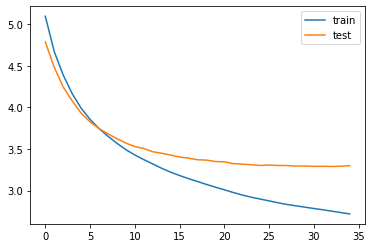

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
reverse_target_word_index=y_tknizer.index_word
reverse_source_word_index=x_tknizer.index_word
target_word_index=y_tknizer.word_index

In [ ]:
# Encoding our input seq for feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

dec_emb2= dec_emb_layer(decoder_inputs) 

# initial states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# softmax for probability
decoder_outputs2 = decoder_dense(decoder_outputs2) 

decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
def sequence_to_summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def sequence_to_text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

###Predict and print summaries from model

In [ ]:
for i in range(0,10):
    print("Review:",sequence_to_text(x_tr[i]))
    print("Original summary:",(sequence_to_summary(y_tr[i])).replace('start', '').replace('end', ''))
    print("Predicted summary:",(decode_sequence(x_tr[i].reshape(1,max_text_len))).replace('start', '').replace('end', ''))
    print("\n")

Review: pope francis on tuesday called for respect for each ethnic group in speech delivered in myanmar avoiding reference to the rohingya minority community as the nation works to restore peace the healing of wounds must be priority he said the pope myanmar visit comes amid the country military crackdown resulting in the rohingya refugee crisis 
Original summary:  pope avoids mention of rohingyas in key myanmar speech  
Predicted summary:   pope calls for rohingya muslims in myanmar 


Review: students of government school in uttar pradesh sambhal were seen washing dishes at in school premises on being approached basic shiksha adhikari virendra pratap singh said yes have also received this complaint from elsewhere we are inquiring and action will be taken against those found guilty 
Original summary:  students seen washing dishes at govt school in up  
Predicted summary:   up school students protest up school in up 


Review: apple india profit surged by 140 in 2017 18 to crore compar

#Calculating scores

###Function to calculate BLEU, GLEU and METEOR scores

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.gleu_score import sentence_gleu
from nltk.translate.meteor_score import meteor_score

def calculate_scores(N=100):    
    bscore=0;gscore=0;mscore=0
    for i in range(N):
        ref=sequence_to_summary(y_tr[i])
        hypo=decode_sequence(x_tr[i].reshape(1,max_text_len))
        bscore+=sentence_bleu([ref],hypo)
        gscore+=sentence_gleu([ref],hypo)
        mscore+=meteor_score([ref],hypo)
    print("BLEU:%.4f GLEU:%.4f METEOR:%.4f"%(bscore/N,gscore/N,mscore/N))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


###Calculating score metrics for first 100

In [ ]:
calculate_scores()

BLEU:0.4279 GLEU:0.4700 METEOR:0.3422
